In [1]:
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 18.7 MB/s eta 0:00:00


# 1. Import data

In [2]:
import pandas as pd

filename = 'bios.csv'

texts = pd.read_csv(filename)['text']

# 2. Import pre-trained model

In [3]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch

pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

# 3. Load data to fast.ai Learner

In [4]:
from fastai.text.all import *

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks)).to(device).long()
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [5]:
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

In [6]:
# Replace predictions with only its first element to allow fine-tuning
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [7]:
def get_learner(train_pct=0.7):
    
    '''Function that load data into fast.ai and create a fast.ai learner using the data.'''
    
    # Transform texts into token : id mappings
    l = len(texts)
    train_len = int(l * train_pct)
    splits = [range_of(train_len), list(range(train_len, l))]
    tls = TfmdLists(texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
    
    # Create a dataloader object that contains attributes used in training loop
    bs,sl = 4,256 # batch_size, sequence_length
    dls = tls.dataloaders(bs=bs, seq_len=sl)
    
    # Create a learner for our use
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                    splitter = splitter, cbs=[DropOutput], 
                    metrics=[accuracy, Perplexity()]).to_fp16()
    
    return learn

In [29]:
learn = get_learner()

# 4. Defining fine-tuning steps

In [26]:
def initial_fine_tune(learn):
    
    '''Function that applies 1 epoch to frozen pre-trained model.'''
    
    # Print metrics without fine-tuning
    learn.validate()
    
    # Freeze pre-trained model
    learn.freeze()
    
    # Fine-tune once
    lr = learn.lr_find().valley
    learn.fit_one_cycle(1, lr)
    
    learn.recorder.plot_loss()
    
    learn.save("1epoch")
    
    return learn, lr

In [10]:
def fine_tune_10epoch(learn, lr):
    
    '''Function that applies 10 epoch to frozen pre-trained model.
    Use lr from `initial_fine_tune()`'''
    
    # Freeze pre-trained model
    learn.freeze()
    
    # Fine-tune for 10 epochs
    lr *= 1/10
    learn.fit_one_cycle(10, lr)
    
    # Save
    learn.save("10epoch")
    
    return learn

In [46]:
def fine_tune_unfreeze_2_layers(learn, lr, num_epoch=1):
    
    '''Function that applies 1 epoch to model that have the last 2 layers unfrozen.
    Use lr from `initial_fine_tune()`'''
    
    learn.freeze_to(-2)
    
    lr *= 1/2
    learn.fit_one_cycle(num_epoch, slice(lr/(2.6**4),lr))
    
    learn.recorder.plot_loss()
    
    learn.save("unfreeze_2_layers")
    
    return learn, lr

In [56]:
def fine_tune_unfreeze_3_layers(learn, lr, num_epoch=1):
    
    '''Function that applies 1 epoch to model that have the last 3 layers unfrozen.
    Use lr from `fine_tune_unfreeze_2_layers()`'''
    
    learn.freeze_to(-3)
    
    lr *= 1/5
    learn.fit_one_cycle(num_epoch, slice(lr/(2.6**4),lr))
    
    learn.recorder.plot_loss()
    
    learn.save("unfreeze_3_layers")
    
    return learn

In [43]:
def fine_tune_unfreeze(learn, lr, num_epoch=2):
    
    '''Function that applies 1 epoch to model that have all layers unfrozen.
    Use lr from `fine_tune_unfreeze_2_layers()`'''
    
    learn.unfreeze()
    
    learn.fit_one_cycle(num_epoch, slice(lr/(2.6**4),lr))
    
    learn.recorder.plot_loss()
    
    learn.save("fine-tuned")
    
    return learn

In [14]:
prompts = ["I've founded", "Dedicated Film professional", "Machine Learning Engineer", 
           "I'm a business professional", "I'm a content creator", "Passionate Animator"]
max_len = 75

In [15]:
def evaluate_with_prompts(learn, prompts, max_len=50):
    for prompt in prompts:
        prompt_ids = tokenizer.encode(prompt)
        inp = tensor(prompt_ids)[None].cuda()
        preds = learn.model.generate(inp, max_length=max_len, num_beams=10, temperature=1.5)
        generated_bio = tokenizer.decode(preds[0].cpu().numpy())
        print(generated_bio)

# 5. Trying out fine-tuning steps

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.634264,3.868498,0.321437,47.870411,01:50


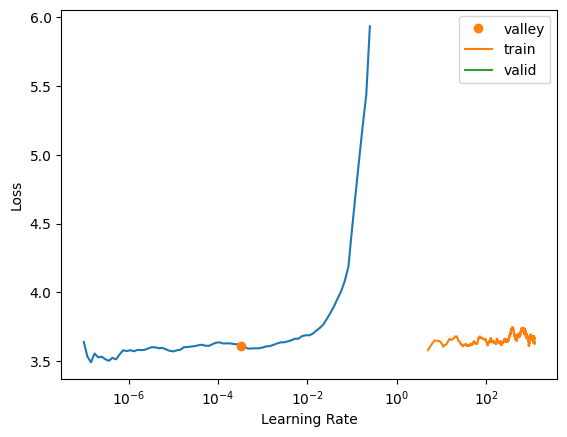

In [30]:
learn, lr = initial_fine_tune(learn)

In [32]:
learn = fine_tune_10epoch(learn, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.594381,3.872147,0.320925,48.045410,01:49
1,3.582443,3.867119,0.321517,47.804478,01:50
2,3.532298,3.865926,0.321815,47.747478,01:49
3,3.550032,3.864391,0.321899,47.674236,01:50
4,3.551959,3.865845,0.321988,47.743622,01:50
5,3.522732,3.865924,0.322134,47.747375,01:50
6,3.505229,3.866523,0.322061,47.775970,01:51
7,3.550621,3.866609,0.322064,47.780071,01:53
8,3.481249,3.867283,0.321986,47.812286,01:52
9,3.491916,3.867005,0.322048,47.799007,01:50


In [34]:
learn.save(f'10epoch_lr{round(lr, 5)}')

Path('models/10epoch_lr0.00033.pth')

In [33]:
lr

0.0003311311302240938

In [47]:
learn.load("10epoch_lr0.00033")
# evaluate_with_prompts(learn, prompts)

In [36]:
learn.validate() # Proves that we successfully loaded the learner

(#3) [3.867004871368408,0.32204753160476685,47.799007415771484]

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.520464,3.844811,0.322852,46.749859,01:51
1,3.397330,3.834012,0.323691,46.247704,01:54
2,3.378972,3.843029,0.323746,46.666592,01:56


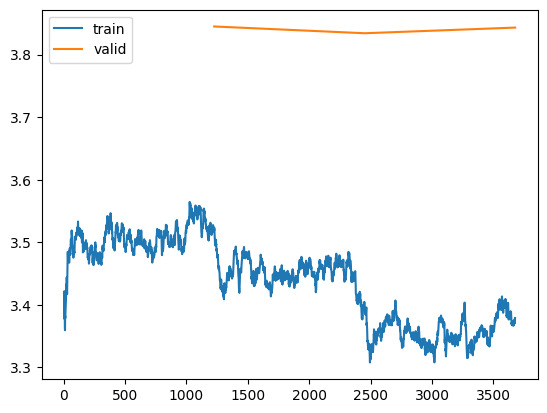

In [48]:
learn, lr2 = fine_tune_unfreeze_2_layers(learn, lr, 3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.336808,3.842072,0.323820,46.621998,01:55
1,3.317950,3.842168,0.323915,46.626465,01:55
2,3.267670,3.843858,0.324068,46.705326,01:56


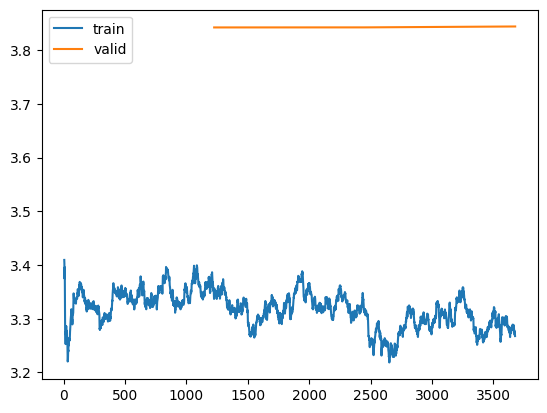

In [51]:
learn = fine_tune_unfreeze_3_layers(learn, lr2, 3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.311338,3.844131,0.324101,46.718079,01:56
1,3.325468,3.844718,0.323584,46.745476,01:57
2,3.234654,3.850857,0.324751,47.033356,02:02
3,3.097637,3.869515,0.324384,47.919159,02:00
4,3.078905,3.881594,0.324154,48.501484,01:57


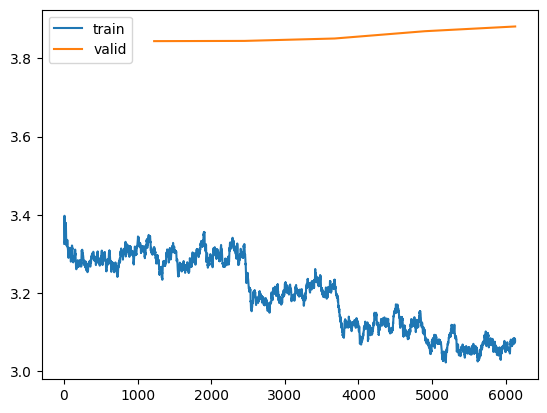

In [52]:
learn = fine_tune_unfreeze(learn, lr2, 5)

In [54]:
learn.save(f"finetuned_lr{round(lr, 5)}_5cycle")

Path('models/finetuned_lr0.00033_5cycle.pth')

In [55]:
evaluate_with_prompts(learn, prompts)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I've founded a non-profit organization dedicated to educating the public about mental health and advocating for the rights and well-being of the mentally disabled. Our mission is to educate the public about mental health and advocating for the rights and well-being of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Dedicated Film professional with a demonstrated history of working in the Film & Television industry. Skilled in Photography, Videography, Photography, and Film Production. Strong arts and design professional with a Bachelor of Fine Arts (BFA) focused in Film


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Machine Learning Engineer with a demonstrated history of working in the information technology and services industry. Skilled in Python, Java, C, C++, C#, and SQL. Strong engineering professional with a Bachelor of Science (B.S.) focused in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm a business professional with a demonstrated history of working in the information technology and services industry. Skilled in Microsoft Excel, Salesforce, Salesforce.com, and Salesforce CRM. Strong information technology professional with a Bachelor's degree focused in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm a content creator, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist, content strategist
Passionate Animator with a demonstrated history of working in the animation industry. Strong arts and design professional with a Bachelor of Fine Arts (BFA) focused in Fine Arts from California State University, Fullerton.I am a recent graduate of the


In [41]:
lr2

0.0001655655651120469